In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal

import glob
import pickle

from utils import *
import collections

In [2]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

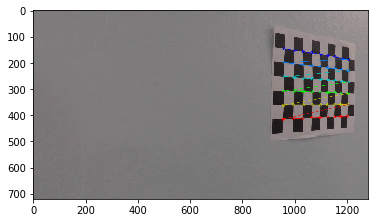

In [3]:
for image in images:

    # Read in image
    img = cv2.imread(image)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

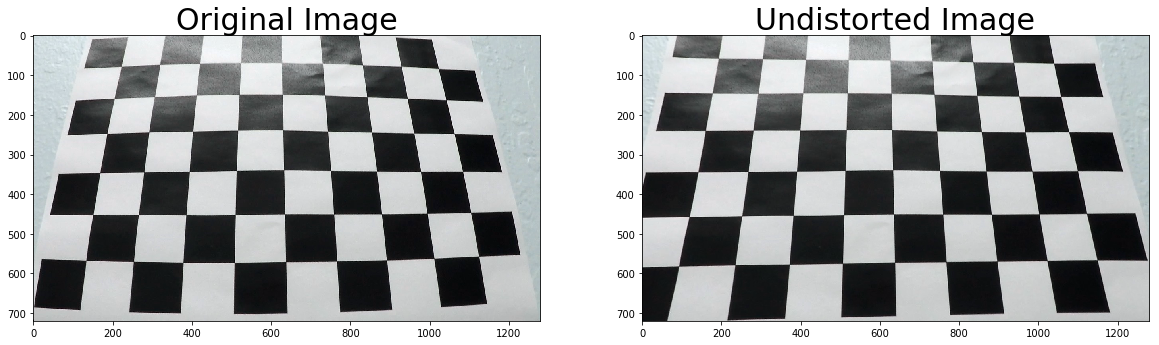

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
# Save the camera calibration result.
save = {
    "mtx" : mtx,
    "dist" : dist   
}

pickle.dump( save, open( "camera_calibration.p", "wb" ) )

Pipeline (single images)
1. Has the distortion correction been correctly applied to each image?

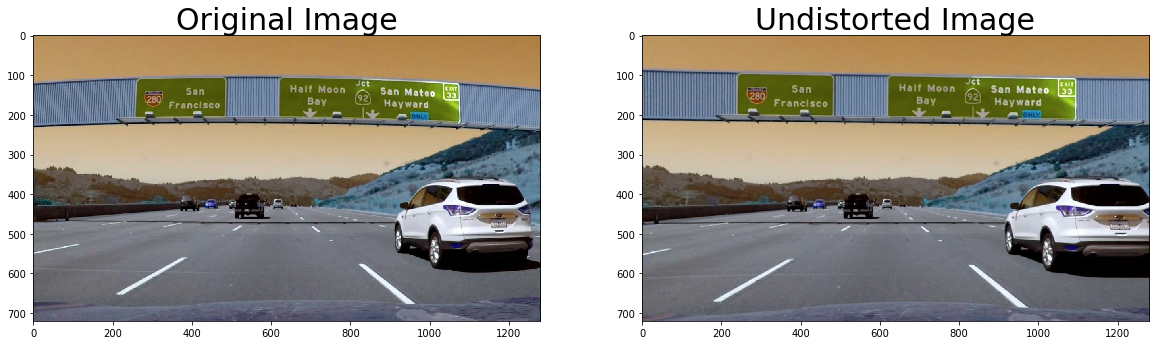

In [6]:
raw = cv2.imread("test_images/signs_vehicles_xygrad.png")
#raw = cv2.imread("test_images/test5.jpg")

#raw = cv2.imread("1050.jpg")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

2. Has a binary image been created using color transforms, gradients or other methods?

In [7]:
# Parameters
imshape = raw.shape

"""
height = raw.shape[0]
offset = 50
offset_height = height - offset
half_frame = raw.shape[1] // 2
steps = 6
pixels_per_step = offset_height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40
"""

height = raw.shape[0]
#    offset = 50
#    offset_height = height - offset
half_frame = raw.shape[1] // 2
steps = 6
pixels_per_step = height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40

blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

In [8]:
def convert_binary_test(img, s_thresh=(170, 255), sx_thresh=(20, 100), sy_thresh=None, l_thresh=None):
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Cont'd: Threshold colour channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Sobel x
#    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
#    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
#    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    
    # Sobel y
    if sy_thresh:
    
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
        abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Threshold x gradient
        sybinary = np.zeros_like(scaled_sobely)
        sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    

    # Threshold colour channel

    # Convert to HLS colour space and separate the S channel
    # Note: img is the undistorted image

    
    if l_thresh:
    
        l_channel = hls[:,:,1]

    # Cont'd: Threshold colour channel
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    
    if(l_thresh and sy_thresh):
        combined_binary[(s_binary == 1) & (l_binary == 1) | (sxbinary == 1) & (sybinary == 1) ] = 1
    
    if(l_thresh and not sy_thresh):
        combined_binary[(s_binary == 1) & (l_binary == 1) | (sxbinary == 1) ] = 1
        
    if(sy_thresh and not l_thresh):
        combined_binary[(l_binary == 1) | (sxbinary == 1) & (sybinary == 1) ] = 1
        
    if(not sy_thresh and not l_thresh):
        combined_binary[(s_binary == 1) | (sxbinary == 1) ] = 1

    return combined_binary, color_binary 

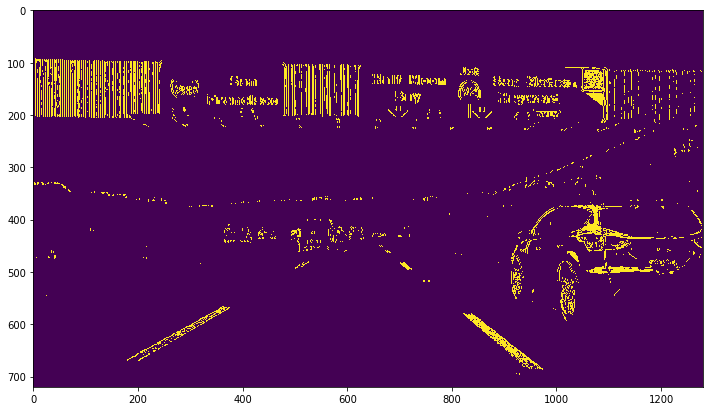

In [39]:
#s_thresh=(150, 255)
#sx_thresh=(40, 100)

s_thresh=(150, 255)
sx_thresh=(40, 100)
sy_thresh=(20, 100)
l_thresh = (100,255)



combined_binary, color_binary = convert_binary_test(image, s_thresh=s_thresh, sx_thresh=sx_thresh, 
                                                              sy_thresh=None, l_thresh=l_thresh)
plt.rcParams["figure.figsize"] = (12,9)
plt.imshow(combined_binary)

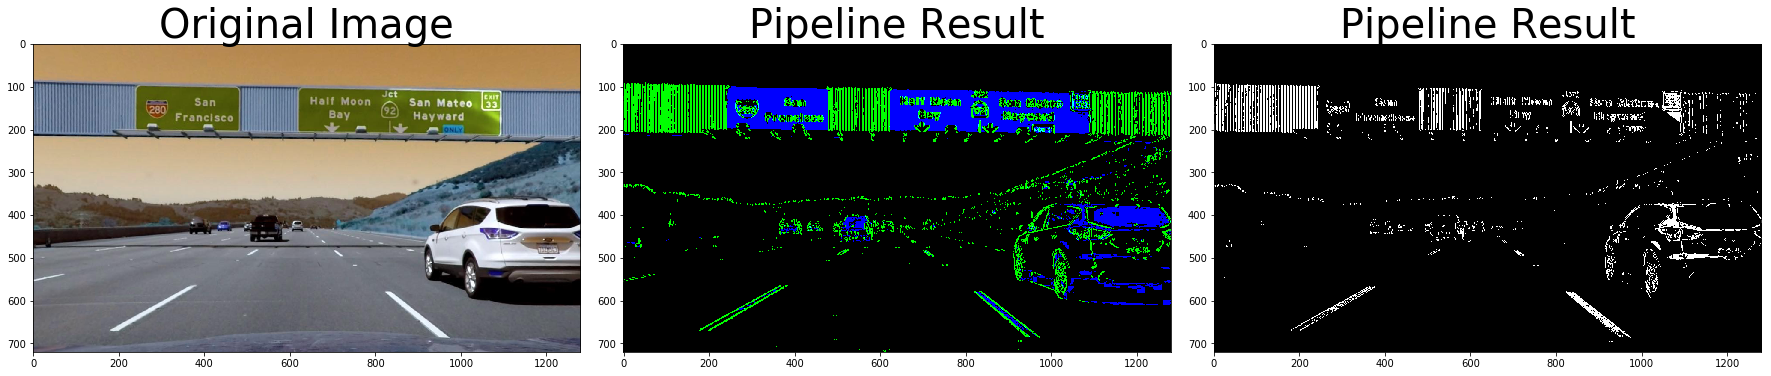

In [40]:
#combined_binary,b = convert_binary_test(image)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(b)
ax2.set_title('SobelX, HLS', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(combined_binary, cmap="gray")
ax3.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

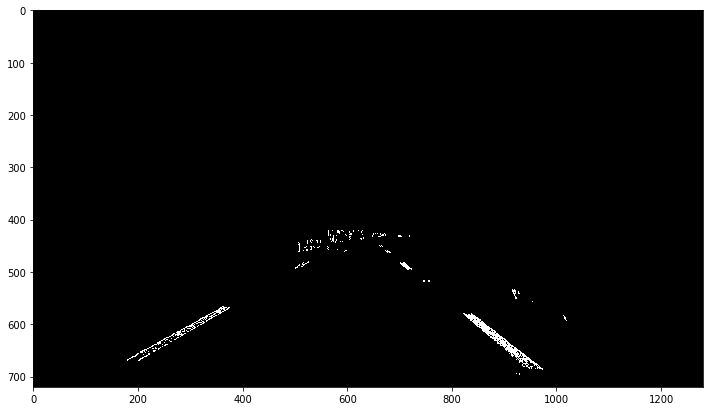

In [41]:
vertices = np.array([[(0,imshape[0]),(550, 420), (700, 420), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

In [42]:
"""
src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[150,720],
     [150,0],
     [1130,0],
     [1130,720]])

"""
src = np.float32([
    [120, image.shape[0]],
    [image.shape[1]/2 - 60, image.shape[0]-image.shape[0]/2+110],
    [image.shape[1]/2 + 60, image.shape[0]-image.shape[0]/2+110],
    [image.shape[1] - 120, image.shape[0]]
    ])

"""
dst = np.float32([
    [150,image.shape[0]],
     [150 + 50,0],
     [image.shape[1] - 150 - 50,0],
     [image.shape[1] - 150,image.shape[0]]
    ])  
"""   

dst = np.float32([
    [150,image.shape[0]],
     [150 + 80,0],
     [image.shape[1] - 150 - 80,0],
     [image.shape[1] - 150,image.shape[0]]
    ])    
    
print(image.shape)
print(image.shape[0])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

print(src)
print(dst)

(720, 1280, 3)
720
[[  120.   720.]
 [  580.   470.]
 [  700.   470.]
 [ 1160.   720.]]
[[  150.   720.]
 [  230.     0.]
 [ 1050.     0.]
 [ 1130.   720.]]


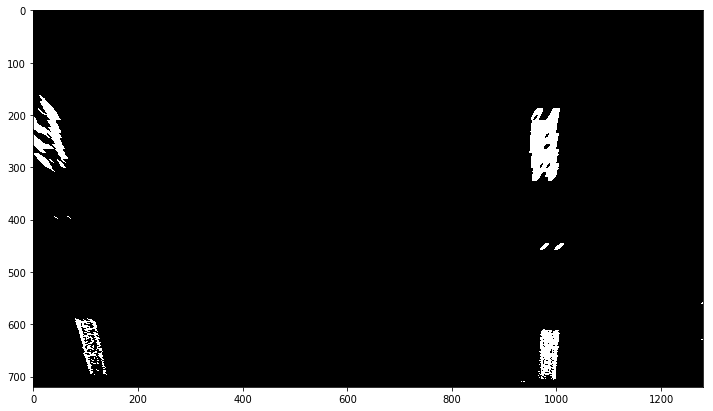

In [43]:
# Warp onto birds-eye-view
# Previous region-of-interest mask's function is absorbed by the warp
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

Have lane line pixels been identified in the rectified image and fit with a polynomial?

In [14]:
# Histogram and get pixels in window

leftx, lefty, rightx, righty, histogram = histogram_pixels(warped, horizontal_offset=horizontal_offset, steps=6,window_radius=200)

print(len(histogram))

print(len(leftx))

6
4696


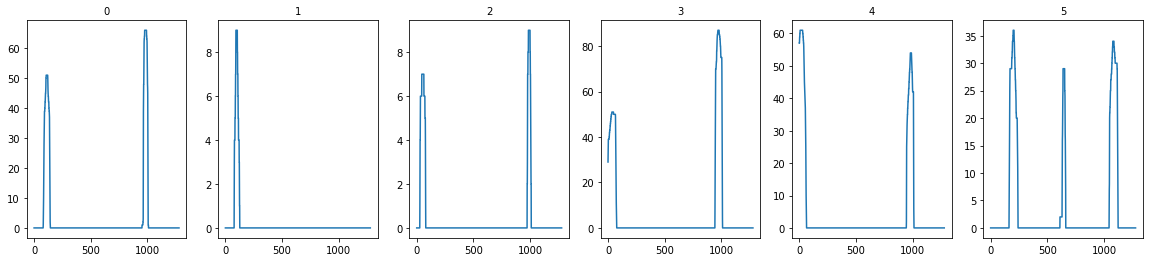

In [15]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20,4))
#ax1.imshow(raw)
ax1.plot(histogram[0])
ax1.set_title('0', fontsize=10)
#ax2.imshow(image)
ax2.plot(histogram[1])
ax2.set_title('1', fontsize=10)

ax3.plot(histogram[2])
ax3.set_title('2', fontsize=10)

ax4.plot(histogram[3])
ax4.set_title('3', fontsize=10)

ax5.plot(histogram[4])
ax5.set_title('4', fontsize=10)

ax6.plot(histogram[5])
ax6.set_title('5', fontsize=10)

In [16]:
left_peaks = np.array(signal.find_peaks_cwt(histogram[0][:600], np.arange(1, 10)))
print(left_peaks)
left_peaks2 = np.array(signal.find_peaks_cwt(histogram[5][:600], np.arange(1, 10)))
print(left_peaks2)
left_peaks3 = np.array(signal.find_peaks_cwt(histogram[0][:600], np.arange(10, 50)))
print(left_peaks3)
left_peaks4 = np.array(signal.find_peaks_cwt(histogram[4][:600], np.arange(1, 10)))
print(left_peaks4)

[ 91 135 136]
[171 194 205 206 235]
[115]
[ 4 37 54]


In [17]:
print(type(np.arange(1,10)))

<class 'numpy.ndarray'>


In [18]:
def get_pixel_in_window_test(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    
    :size, window_radius=200
    
    """
      
    half_size = size // 2
    
    print(int(y_center - half_size))
    print(int(y_center + half_size))
    print(int(x_center - half_size))
    print(int(x_center + half_size))
    
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

#    x, y = (window.T == 1).nonzero()
    
    x, y = window.nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y, window

def get_pixel_in_window_test2(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    
    :size, window_radius=200
    
    """
      
    half_size = size // 2
    
    print(int(y_center - half_size))
    print(int(y_center + half_size))
    print(int(x_center - half_size))
    print(int(x_center + half_size))
    
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

    x, y = (window.T == 1).nonzero()
    
#    x, y = window.nonzero()

    print("original x %s" % x)
    print("original y %s" % y)

    x = x + x_center - half_size
    y = y + y_center - half_size
    
    print("x %s" % x)
    print("y %s" % y)

    return x, y, window

500
700
90
290
500
700
90
290
original x [ 0  0  0 ..., 52 52 53]
original y [ 88  89  90 ..., 177 183 183]
x [ 90  90  90 ..., 142 142 143]
y [588 589 590 ..., 677 683 683]


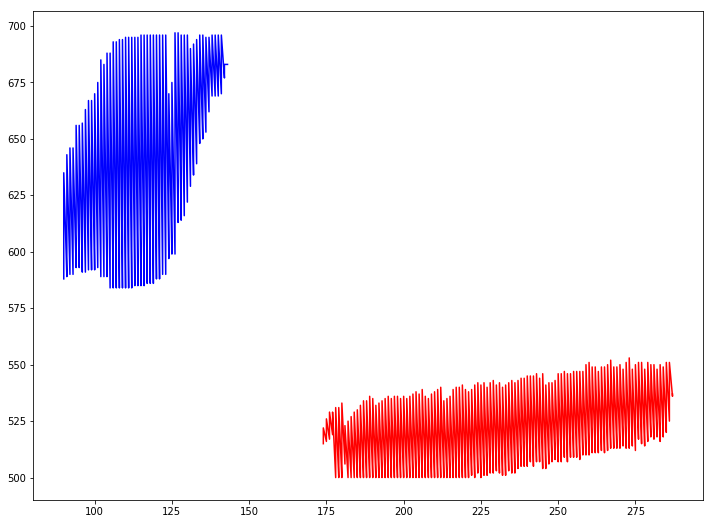

In [19]:
x, y, window = get_pixel_in_window_test(warped, 190,600, 200)
plt.plot(x,y,'r')

x, y, window = get_pixel_in_window_test2(warped, 190,600, 200)
plt.plot(x,y,'b')

In [20]:
print(leftx)
print(len(leftx))

[ 78  78  78 ..., 132 132 133]
4696


left_fit: [  98.33153458   98.84677003   99.36091849 ...,  111.61800675  111.86135771
  111.86135771]
left_fit: 4696
Left coeffs: [ -1.35873941e-04   4.16861984e-01  -9.90332667e+01]
righty[0]: , 718.0 , rightx[0]:  912
Right coeffs:  [  7.48781733e-04  -6.66330078e-01   1.09839622e+03]


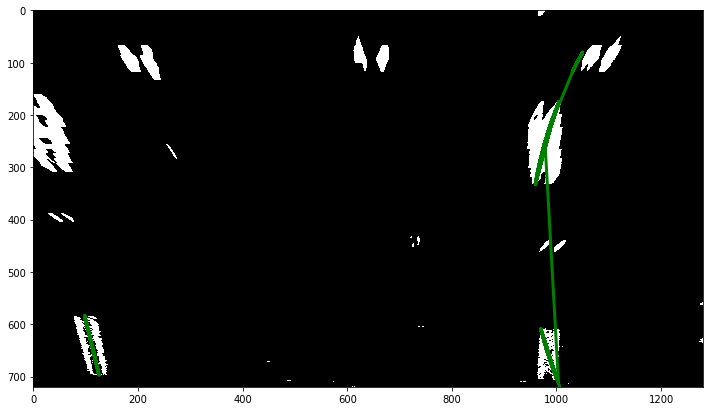

In [21]:
# Fit a second order polynomial to each fake lane line
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("left_fit:", left_fit)
print("left_fit:", len(left_fit))


print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)

# Plot data

plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

In [22]:
def lane_poly_test(yval, poly_coeffs):
    """Returns x value for poly given a y-value.
    Note here x = Ay^2 + By + C."""
    
    print("lane_poly is called")
    
    return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]

def draw_poly_test(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

Left coeffs:  [ -1.35873941e-04   4.16861984e-01  -9.90332667e+01]
Right coeffs:  [  7.48781733e-04  -6.66330078e-01   1.09839622e+03]
(720, 1280)


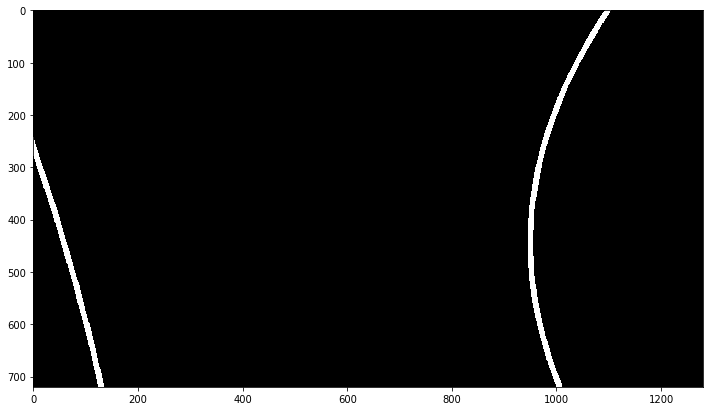

In [23]:
print("Left coeffs: ", left_coeffs)
print("Right coeffs: ", right_coeffs)
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")
print(polyfit_drawn.shape)

In [24]:
def evaluate_poly_test(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]

In [25]:
def cal_curverad(ploty_left, leftx, ploty_right, rightx, y_eval ):
    
    y_eval = y_eval

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/850 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty_left*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty_right*ym_per_pix, rightx*xm_per_pix, 2)
    
    print('left_fit_cr')
    print(left_fit_cr)
    
    print('right_fit_cr')
    print(right_fit_cr)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('left' ,left_curverad, 'm, right', right_curverad, 'm')
    
    return left_curverad, right_curverad

In [26]:
def highlight_lane_line_area_test(mask_template, left_poly, right_poly, start_y=0, end_y =720):
    area_mask = mask_template
    for y in range(start_y, end_y):
        left = evaluate_poly_test(y, left_poly)
        right = evaluate_poly_test(y, right_poly)
        area_mask[y][int(left):int(right)] = 1

    return area_mask

<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280)
255.0


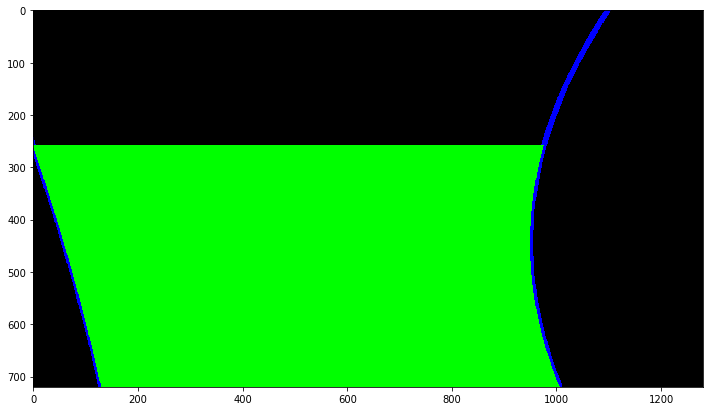

In [27]:
trace = colour_canvas
print(type(trace))
print(trace.shape)
#print(trace)
print(type(polyfit_drawn))
print(polyfit_drawn.shape)
print(np.max(polyfit_drawn))
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In [28]:
# Determine curvature of the lane
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
#y_eval = 500
y_eval = imshape[0]
print('y_eval is %d' % y_eval)

"""
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
"""


print('lefty')
print(lefty)
print(type(lefty))
print(len(lefty))
print('leftx')
print(leftx)
print(len(leftx))
print(type(leftx))
left_curverad, right_curverad = cal_curverad(lefty, leftx, righty, rightx, y_eval)


curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

print("center: ", centre, "pixels")

y_eval is 720
lefty
[ 585.  587.  589. ...,  638.  639.  639.]
<class 'numpy.ndarray'>
4696
leftx
[ 78  78  78 ..., 132 132 133]
4696
<class 'numpy.ndarray'>
left_fit_cr
[ -3.40675933e-04   4.35498167e-02  -4.31085984e-01]
right_fit_cr
[  1.87741603e-03  -6.96118952e-02   4.78125415e+00]
left 1468.84629267 m, right 267.063622169 m
center:  -405.361196696 pixels


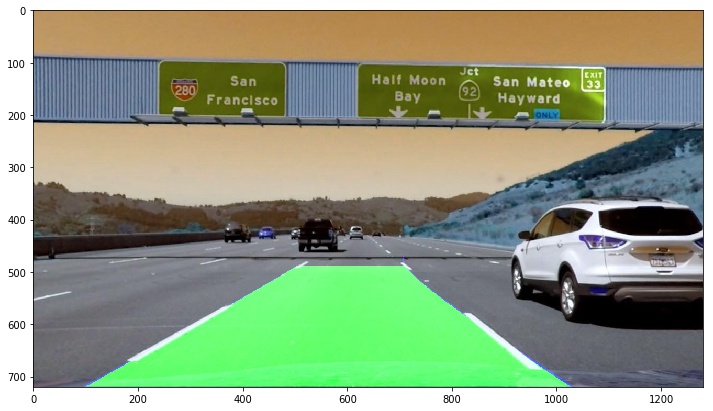

In [30]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to colour
combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img)

In [31]:
def add_figures_to_image_test(img, curvature, vehicle_position, min_curvature, frame_no, left_coeffs=(0,0,0), 
                              right_coeffs=(0,0,0)):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    """
    # Convert from pixels to meters
    vehicle_position = vehicle_position / 12800 * 3.7
    curvature = curvature / 128 * 37 
    min_curvature = min_curvature / 128 * 37 
    """
    
    vehicle_position = vehicle_position / 12800 * 3.7
    curvature = curvature 
    min_curvature = min_curvature 

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "left" if vehicle_position < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    cv2.putText(img, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Left poly coefficients = %.3f %.3f %.3f' % (left_coeffs[0], left_coeffs[1], left_coeffs[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Right poly coefficients = %.3f %.3f %.3f' % (right_coeffs[0], right_coeffs[1], right_coeffs[2]), (50, 250), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'frame no = %d' % frame_no, (50, 300), 
                    font, 1, (255, 255, 255), 2)

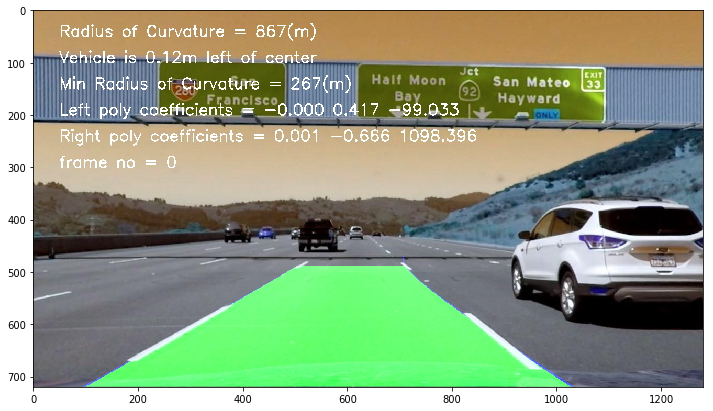

In [32]:
add_figures_to_image_test(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     frame_no = 0,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)

plt.rcParams["figure.figsize"] = (12,9)
plt.imshow(combined_img)

In [33]:
def fit_second_order_poly_test(indep, dep, return_coeffs=False):
    
    print("indep")
    print(indep)
    
    fit = np.polyfit(indep, dep, 2)
    
    bottom = fit[0] * 720 ** 2 +  fit[1] * 720 + fit[2]
    
    print(bottom)
    
    
    fitdep = fit[0]*indep**2 + fit[1]*indep + fit[2]
    if return_coeffs == True:
        return fitdep, fit, bottom
    else:
        return fitdep, bottom

leftx
[ 80  80  80 ..., 128 128 129]
<class 'numpy.ndarray'>
lefty
[ 589.  591.  594. ...,  635.  639.  633.]
<class 'numpy.ndarray'>
indep
[ 589.  591.  594. ...,  635.  639.  633.]
128.033121898
Left coeffs: [ -1.18086782e-04   3.88349368e-01  -9.03622351e+01]
righty[0]: , 709.0 , rightx[0]:  932
indep
[ 709.  709.  709. ...,  188.  189.  190.]
987.347193361
Right coeffs:  [  3.17039644e-05  -8.33204615e-03   9.76910931e+02]
left_fit_cr
[ -2.96078294e-04   4.05710869e-02  -3.93341494e-01]
right_fit_cr
[  7.94911635e-05  -8.70453763e-04   4.25243582e+00]
left 1690.06022979 m, right 6290.15074951 m
leftx debugging
[ 80  80  80 ..., 128 128 129]
3187
lefty debugging
[ 589.  591.  594. ...,  635.  639.  633.]
3187
Left coeffs:  [ -1.18086782e-04   3.88349368e-01  -9.03622351e+01]
Right fit:  [  3.17039644e-05  -8.33204615e-03   9.76910931e+02]
polyfit shape:  (720, 1280)


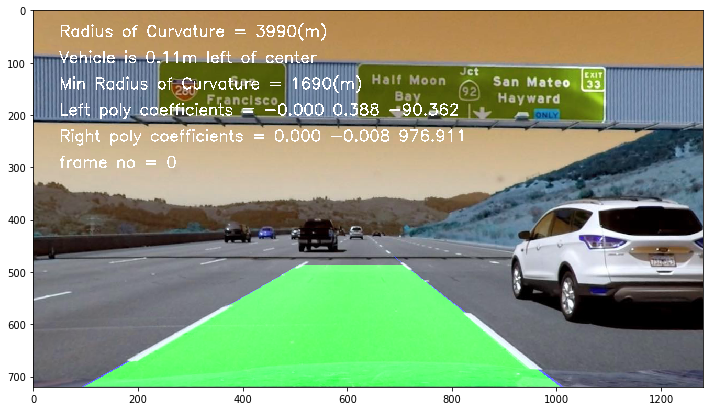

In [37]:
with open("camera_calibration.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

prev_left_coeffs = None
prev_right_coeffs = None

frame_no = -1



def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    global frame_no
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
        
    src = np.float32([
    [120, imshape[0]],
    [imshape[1]/2 - 60, imshape[0]-imshape[0]/2+110],
    [imshape[1]/2 + 60, imshape[0]-imshape[0]/2+110],
    [imshape[1] - 120, imshape[0]]
    ])

    dst = np.float32([
    [150,imshape[0]],
    [150 + 80,0],
    [imshape[1] - 150 - 80,0],
    [imshape[1] - 150,imshape[0]]
    ])       
    
    
   

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    imshape = raw.shape

    height = raw.shape[0]
#    offset = 50
#    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = height / steps
    window_radius = 200
    medianfilt_kernel_size = 51
    horizontal_offset = 40





    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
#    combined = apply_thresholds(image)

    ## Option II

    have_fit = False
#    curvature_checked = False

    s_thresh=(150, 255)
    sx_thresh=(40, 100)
    sy_thresh=(20, 100)
    l_thresh = (100,255)

    while have_fit == False:
#        combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
        combined_binary , color_binary  = convert_binary_test(image, s_thresh=s_thresh, sx_thresh=sx_thresh, 
                                                                sy_thresh=None, l_thresh=l_thresh)
    #    plt.imshow(combined_binary, cmap="gray")

        # Plotting thresholded images
        """
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Option 1')
        ax1.imshow(combined, cmap="gray")

        ax2.set_title('Option 2: Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        """

        # Warp onto birds-eye-view
        # Previous region-of-interest mask's function is absorbed by the warp
        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
        # plt.imshow(warped, cmap="gray")

        # Histogram and get pixels in window

#        leftx, lefty, rightx, righty, histograms = histogram_pixels(warped, horizontal_offset=40)
        leftx, lefty, rightx, righty, histograms = histogram_pixels(warped, horizontal_offset=horizontal_offset, steps=6,window_radius=200)

        
        print('leftx')
        print(leftx)
        print(type(leftx))
        print('lefty')
        print(lefty)
        print(type(lefty))

        plt.imshow(warped, cmap="gray")

        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
            
#        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)

    left_fit, left_coeffs, left_bottom = fit_second_order_poly_test(lefty, leftx, return_coeffs=True)
    print("Left coeffs:", left_coeffs)
    print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
    right_fit, right_coeffs, right_bottom = fit_second_order_poly_test(righty, rightx, return_coeffs=True)
    print("Right coeffs: ", right_coeffs)
    
  

    # Plot data
    """
    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")
    """

    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    # y_eval = 500
    y_eval = imshape[0]
    
    """
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                    /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     /(2 * right_coeffs[0]))
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)
    """
    
    left_curverad, right_curverad = cal_curverad(lefty, leftx, righty, rightx, y_eval)
    print('leftx debugging')
    print(leftx)
    print(len(leftx))
    print('lefty debugging')
    print(lefty)
    print(len(lefty))
    
    
    curvature = (left_curverad + right_curverad) / 2
    min_curverad = min(left_curverad, right_curverad)
    
    if((right_bottom - left_bottom) < 700):
        left_coeffs = prev_left_coeffs
        right_coeffs = prev_right_coeffs
        
    prev_left_coeffs = left_coeffs
    prev_right_coeffs = right_coeffs

    
    # Det vehicle position wrt centre
    centre = center(719, left_coeffs, right_coeffs)
        
    ## 7. Warp the detected lane boundaries back onto the original image.

    print("Left coeffs: ", left_coeffs)
    print("Right fit: ", right_coeffs)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
#    plt.imshow(polyfit_drawn, cmap="gray")
#    plt.imshow(warped)

    # Convert to colour and highlight lane line area
    trace = colour_canvas
    trace[polyfit_drawn > 1] = [0,0,255]
    print("polyfit shape: ", polyfit_drawn.shape)
    area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]
    # plt.imshow(trace)
    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(trace)

    combined_img = cv2.add(lane_lines, image)
    frame_no = frame_no + 1
    
   
        
    
    add_figures_to_image_test(combined_img, curvature=curvature, 
                         vehicle_position=centre, 
                         min_curvature=min_curverad,
                         frame_no = frame_no,
                         left_coeffs=left_coeffs,
                         right_coeffs=right_coeffs)
    """
    if(frame_no == 1050):
        filename =  str(frame_no) + '.jpg'
        cv2.imwrite( filename, raw )
        
    if(frame_no < 90 and frame_no > 70):
        filename =  str(frame_no) + '.jpg'
        cv2.imwrite( filename, raw )
    """      
    
    plt.imshow(combined_img)
    return combined_img,warped,combined_binary 

combined_img,warped, combined_binary  = image_pipeline("test_images/signs_vehicles_xygrad.png", filepath=True)

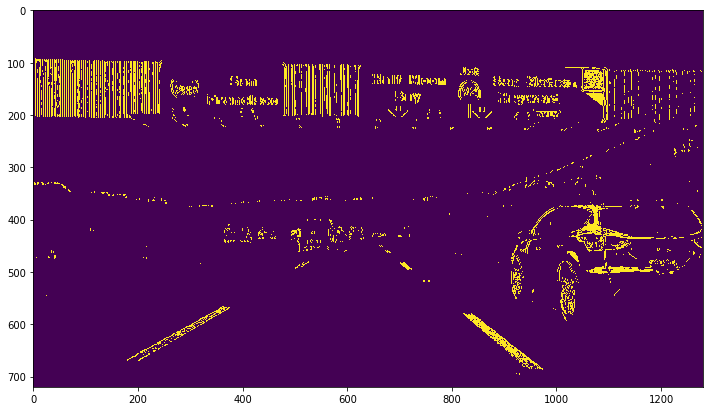

In [38]:
plt.imshow(combined_binary)

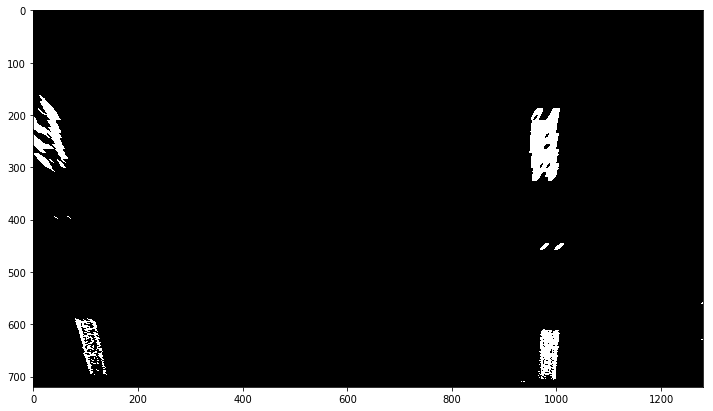

In [36]:
plt.imshow(warped, cmap="gray")

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
video_dir = "../../../CarND-Advanced-Lane-Lines/project_video.mp4"

output = 'project_output_colour.mp4'
clip1 = VideoFileClip(video_dir)
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)